In [1]:
%cd /home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code

/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code


In [2]:
pip uninstall -y giverny

Note: you may need to restart the kernel to use updated packages.


<hr style = "height:6px;border:none;background-color:sienna">

<h2 style = "font-weight:bold;font-style:italic">
    turbulence2 demo notebook
</h2>

<p style = "font-weight:bold;font-size:13px">
    &emsp;- stable release version 2023.04.21
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> :
    <br>
    &emsp;- SciServer processing of JHU turbulence datasets.
    <br>
    &emsp;- note: parallel dask workers need ~ 5 GB of memory for every complete database file (1.5 GB) they will read.
    <br><br>
    <u>supported datasets</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        isotropic4096 &ensp;: &ensp;isotropic 4096-cube.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        isotropic8192 &ensp;: &ensp;isotropic 8192-cube.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>functions</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        getPressure &ensp;: &ensp;retrieve and interpolate pressures for sparse points.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        getVelocity &ensp;: &ensp;retrieve and interpolate velocities for sparse points.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        getCutout &ensp;: &ensp;read data for a user-specified box.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        dataValues &ensp;: &ensp;see values for specific point(s) in the getCutout data.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        contourPlot &ensp;: &ensp;create a contour plot of getCutout data.
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

<h4 style = "font-weight:bold;font-style:italic">
    instantiate dataset
</h4>

<p style = "font-weight:bold;font-size:13px">
    &emsp;n.b. &ensp;: &ensp;the metadata is stored in pickle files in the "pickled" folder. if processing fails, delete the 
    pickle files and try again.
    <br>
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> : 
    <br>
    &emsp;- instantiate the dataset and cache the metadata.
    <br>

</p>

<p style = "font-weight:bold;font-size:13px">
    <u>parameters</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        dataset_title &ensp;: &ensp;name of the turbulence dataset.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        output_path &ensp;: &ensp;folder path in the "scratch" folder of the "Temporary" directory of the user's SciServer container.
        <br>
        &emsp;- default (if left blank) &ensp;: &ensp;/home/idies/workspace/Temporary/USERNAME/scratch/turbulence_output
        <br>
        &emsp;- output files will be saved in this folder.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>output</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        dataset &ensp;: &ensp;instantiated dataset.
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

In [3]:
"""
instantiate dataset
"""
from giverny.isotropic_cube import *

# user-defined parameters.
# -----
dataset_title = 'sabl2048b'

output_path = ''

# -----
# generates the morton cube representing the turbulence dataset.
dataset = iso_cube(dataset_title = dataset_title, output_path = output_path)

<hr style = "height:6px;border:none;background-color:sienna">

<h4 style = "font-weight:bold;font-style:italic">
    getCutout
</h4>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> : 
    <br>
    &emsp;- retrieving the user-requested box.
    <br>
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>steps</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        step 1 &ensp;: &ensp;identify the database files to be read.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        step 2 &ensp;: &ensp;read the database files and store the data in a matrix.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        step 3 &ensp;: &ensp;write the matrix to a HDF5 file.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>parameters</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        x_range, y_range, z_range &ensp;: &ensp;axes ranges defining the box for which data values will be read.
        <br>
        &emsp;- specify each axis range as [minimum, maximum].
    </li>
    <br>
    <li style = "font-weight:bold;font-size:13px">
        x_stride, y_stride, z_stride &ensp;: &ensp;axes strides, i.e. the number of points between each step along the axes.
    </li>
    <br>
    <li style = "font-weight:bold;font-size:13px">
        variable &ensp;: &ensp;type of data, e.g. "velocity" or "pressure".
    </li>
    <li style = "font-weight:bold;font-size:13px">
        timepoint &ensp;: &ensp;time point.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>output</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        cutout_data &ensp;: &ensp;matrix corresponding to variable at timepoint in axes_ranges with strides.
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

In [4]:
"""
process getCutout data
"""
from giverny.turbulence_toolkit import *
from giverny.turbulence_gizmos.basic_gizmos import *

# user-defined parameters.
# -----

x_range = [1, 2048]
y_range = [1, 2048]
z_range = [1, 1]

x_stride = 1
y_stride = 1
z_stride = 1

variable = 'energy'
timepoint = 1

# use the tools and processing gizmos.
# -----
# combine all of the axis data together for simplicity.
axes_ranges = assemble_axis_data([x_range, y_range, z_range])
strides = assemble_axis_data([x_stride, y_stride, z_stride])

# process a brick cutout.
cutout_data = getCutout(dataset, variable, timepoint, axes_ranges, strides)

Note: For larger boxes, e.g. 512-cubed and up, processing will take approximately 1 minute or more...
-----

Step 1: Determining which database files the user-specified box is found in...
-------------------------
number of database files that the user-specified box is found in:
16

number of hard disks that the database files are distributed on:
16

Successfully completed.
-----

Step 2: Reading the data from all of the database files and storing the values into a matrix...
-------------------------
Database files are being read in parallel...

Successfully completed.
-----

Step 3: Writing the output matrix to a hdf5 file...
-------------------------

Successfully completed.
-----

step 1 time elapsed = 0.035 seconds (0.001 minutes)
step 2 time elapsed = 11.558 seconds (0.193 minutes)
step 3 time elapsed = 0.000 seconds (0.000 minutes)
total time elapsed = 11.610 seconds (0.194 minutes)

Data processing pipeline has completed successfully.
-----


<hr style = "height:6px;border:none;background-color:sienna">

<h4 style = "font-weight:bold;font-style:italic">
    data values
</h4>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> : 
    <br>
    &emsp;- retrieve the data value(s) for a datapoint (x, y, z), or a range of datapoints, e.g. x = range(1, 5), in the getCutout data.
    <br>
    &emsp;- note: range(min, max) will retrieve data values for points "min" through ("max" - 1).
    <br>
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>parameters</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        x &ensp;: &ensp;x-axis datapoint(s).
    </li>
    <li style = "font-weight:bold;font-size:13px">
        y &ensp;: &ensp;y-axis datapoint(s).
    </li>
    <li style = "font-weight:bold;font-size:13px">
        z &ensp;: &ensp;z-axis datapoint(s).
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>output</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        cutout_value &ensp;: &ensp;data value(s) of the requested datapoint(s).
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

In [5]:
"""
data values
"""
from giverny.turbulence_gizmos.basic_gizmos import *

# user-defined parameters.
# -----
x = 4
y = 5
z = 1

# use the data values gizmo.
# -----
cutout_value = dataValues(dataset, x, y, z, cutout_data, axes_ranges, strides)

cutout_value

endpoints_min:  [4 5 1]
endpoints_max:  [4 5 1]
axes_ranges:  [[1 2048]
 [1 2048]
 [1 1]]


<xarray.DataArray 'Energy_0001' (zcoor: 1, ycoor: 1, xcoor: 1, values: 1)>
array([[[[0.02806808]]]], dtype=float32)
Coordinates:
  * zcoor    (zcoor) float32 0.0
  * ycoor    (ycoor) float32 0.01227
  * xcoor    (xcoor) float32 0.009204
Dimensions without coordinates: values

<hr style = "height:6px;border:none;background-color:sienna">

<h4 style = "font-weight:bold;font-style:italic">
    contour plot
</h4>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> : 
    <br>
    &emsp;- create a contour plot from the getCutout data.
    <br>
    &emsp;- note: one of the axis ranges should be a single point, e.g. z_plot_range = [3, 3], since the contour plot is 2-dimensional.
    <br>
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>parameters</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        x_plot_range &ensp;: &ensp;x-axis plot range.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        y_plot_range &ensp;: &ensp;y-axis plot range.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        z_plot_range &ensp;: &ensp;z-axis plot range.
    </li>
    <br>
    <li style = "font-weight:bold;font-size:13px">
        value_index &ensp;: &ensp;the index of the values to plot.
        <br>
        &emsp;- 1 corresponds to the "ux" velocity component for the velocity data or the pressure magnitude for the pressure data.
        <br>
        &emsp;- 2 corresponds to the "uy" velocity component for the velocity data.
        <br>
        &emsp;- 3 corresponds to the "uz" velocity component for the velocity data.
    </li>
    <br>
    <li style = "font-weight:bold;font-size:13px">
        output_filename &ensp;: &ensp;filename for the contour plot saved in the output_path folder.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>output</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        contour plot &ensp;: &ensp;displayed in the notebook and saved to output_filename in the output_path folder.
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

Generating contour plot...
-----


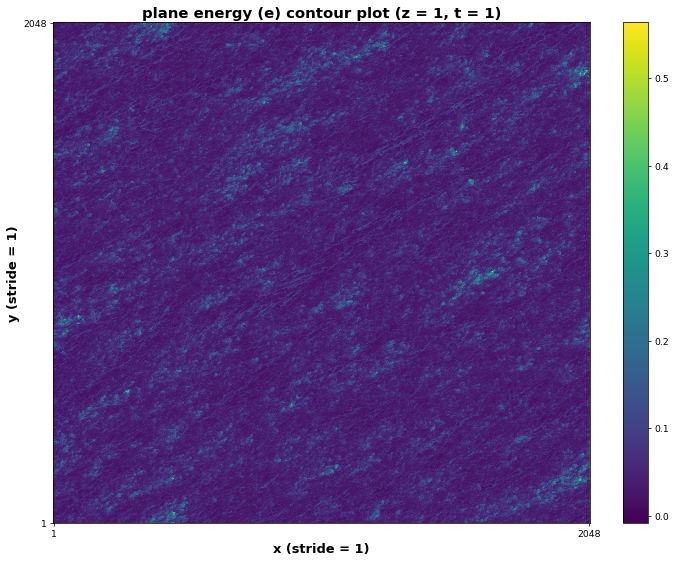

-----
Contour plot created successfully.


In [6]:
"""
contour plot
"""
from giverny.turbulence_gizmos.basic_gizmos import *

# user-defined parameters.
# -----
x_plot_range = [1, 2048]
y_plot_range = [1, 2048]
z_plot_range = [1, 1]

value_index = 1

output_filename = f'turbulence_plane-contour_plot-ncar.png'

# use the tools and contour plot gizmo.
# -----
# combine all of the plot axis ranges together for simplicity.
plot_ranges = assemble_axis_data([x_plot_range, y_plot_range, z_plot_range])

# create the contour plot.
contourPlot(dataset, value_index, cutout_data, plot_ranges, axes_ranges, strides, output_filename)

<hr style = "height:6px;border:none;background-color:sienna">

<h4 style = "font-weight:bold;font-style:italic">
    getPressure and getVelocity
</h4>

<p style = "font-weight:bold;font-size:13px">
    <u>purpose</u> : 
    <br>
    &emsp;- retrieve (and interpolate) a group of sparse data points.
    <br>
</p>

<p style = "font-weight:bold;font-size:13px">
    <u>steps</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        step 1 &ensp;: &ensp;identify the database files to be read.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        step 2 &ensp;: &ensp;read the database files and store the points in an array.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        step 3 &ensp;: &ensp;write the array to a HDF5 file.
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>parameters</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        points &ensp;: &ensp;array of points in the domain [0, 2pi).
    </li>
    <li style = "font-weight:bold;font-size:13px">
        timepoint &ensp;: &ensp;time point.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        sint &ensp;: &ensp;spatial interpolation method.
        <br>
        &emsp;- none &ensp;: &ensp;No Space interpolation (value at the datapoint closest to each coordinate value).
        <br>
        &emsp;- lag4 &ensp;: &ensp;4th-order Lagrange Polynomial interpolation along each spatial direction.
        <br>
        &emsp;- lag6 &ensp;: &ensp;6th-order Lagrange Polynomial interpolation along each spatial direction.
        <br>
        &emsp;- lag8 &ensp;: &ensp;8th-order Lagrange Polynomial interpolation along each spatial direction.
        <br>
        &emsp;- m1q4 &ensp;: &ensp;Splines with smoothness 1 (3rd order) over 4 data points.
        <br>
        &emsp;- m2q8 &ensp;: &ensp;Splines with smoothness 2 (5th order) over 8 data points. 
        <br>
    </li>
</ul>

<p style = "font-weight:bold;font-size:13px">
    <u>output</u> :
</p>

<ul>
    <li style = "font-weight:bold;font-size:13px">
        pressure_data &ensp;: &ensp;array filled with pressures at the requested points.
    </li>
    <li style = "font-weight:bold;font-size:13px">
        velocity_data &ensp;: &ensp;array filled with velocities at the requested points.
    </li>
</ul>

<hr style = "height:6px;border:none;background-color:sienna">

In [7]:
"""
process getVelocity and getPressure data
"""
from giverny.turbulence_toolkit import *
from giverny.turbulence_gizmos.basic_gizmos import *

# user-defined parameters.
# -----
"""
2-D plane demo points.
"""
# npoints3D = 256
# dataset_divisor = 16
# slop = (2 * np.pi * (npoints3D - 1)) / dataset_divisor
# points = np.zeros((npoints3D**2, 3), dtype = np.float32)
# x_begin = 8. * dataset.dx
# x_end = 8. * dataset.dx
# z_ = np.linspace(x_begin,
#                  ((2 * np.pi / dataset_divisor) - x_end),
#                  npoints3D)

# for j in range(npoints3D):
#     for i in range(npoints3D):
#         # this is a horizontal plane.        
#         points[j * npoints3D + i,0] = z_[j]  
#         points[j * npoints3D + i,1] = slop * i * 0 + (512. * 2 + 8.) * dataset.dx
#         points[j * npoints3D + i,2] = z_[i]
        
#         # this is a diaganol plane.
#         #points[j * npoints3D + i, 0] = slop * i
#         #points[j * npoints3D + i, 1] = z_[j]
#         #points[j * npoints3D + i, 2] = slop * i
        
# ---
"""
random demo points.
"""
# npoints3D = 30000

# points = np.random.uniform(low = 520., high = 1016., size = (npoints3D, 3)) * dataset.dx

# ---
"""
3-D demo points.
"""
npoints3D = 1
dataset_divisor = 16

x_begin = dataset.dx * 8
x_ = np.linspace(x_begin,
                 ((2 * np.pi / dataset_divisor) - (8. * dataset.dx)),
                 npoints3D)

y_ = np.linspace(x_begin,
                 ((2 * np.pi / dataset_divisor) - (8. * dataset.dx)),
                 npoints3D)

z_ = np.linspace(x_begin,
                 (2 * np.pi / dataset_divisor) - (8. * dataset.dx),
                 npoints3D)

points = np.vstack(np.meshgrid(x_, y_, z_)).reshape(3, -1).T[: npoints3D**3].astype(np.float32)
    
# -----

timepoint = 1
sint = 'm2q8_h'

# use the tools and processing gizmos. both getPressure and getVelocity are shown for demonstration purposes.
# -----
# # retrieve the interpolated pressures for the datapoints.
# pressure_data = getPressure(dataset, timepoint, sint, points)

# retrieve the interpolated velocities for the datapoints.
velocity_data = getVelocity(dataset, timepoint, sint, points)

print('---')
print(len(velocity_data))

print(f'\npoints = \n-\n{points[:5]}')
print(f'\npoints / dataset.dx = \n-\n{(points / dataset.dx)[:5]}')
print(f'\ninterpolated_data = \n-\n{np.array([(tuple(val[0]), tuple(val[1])) for val in velocity_data[:5]], dtype = object)}')


-------------------------
getVelocity is processing...

Step 1: Sorting the points to native and visitor bucket maps...
-------------------------
len db_native_map = 
1
-
len db_visitor_map = 
0

Successfully completed.
-----

Step 2: Interpolating the data...
-------------------------
Database files are being read sequentially...


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/idies/mambaforge/envs/py39/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/idies/mambaforge/envs/py39/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_writing/giverny/isotropic_cube.py", line 1147, in read_natives_sequentially_variable
    native_output_data += self.get_iso_points_variable(db_native_map[database_file_disk], verbose = False)
  File "/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_writing/giverny/isotropic_cube.py", line 1329, in get_iso_points_variable
    zs = zarr.open(db_file + '_' + str(self.timepoint) + '.zarr' + os.sep + self.var_name, dtype = dt, mode = 'r')
  File "/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/zarr/convenience.py", line 122, in open
    raise PathNotFoundError(path)
zarr.errors

db path:  defaultdict(<function iso_cube.identify_database_file_points.<locals>.<lambda>.<locals>.<lambda> at 0x7faddcef6310>, {'/home/idies/workspace/turb/data01_01/zarr/sabl2048b_01_prod/sabl2048b01': defaultdict(<class 'list'>, {b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00': [(array([0, 0, 0]), array([63, 63, 63]), array([0, 0, 0]), array([63, 63, 63])), (array([0.02454369, 0.02454369, 0.02454369], dtype=float32), array([8, 8, 8]), array([3., 3., 3.], dtype=float32), 0)]})})


ValueError: not enough values to unpack (expected 2, got 0)